In [2]:
import copy
import pandas
import warnings
import subprocess
from matplotlib import pyplot as plt
import os
import sys
from scipy import stats
import pprint

sys.path.insert(0, "../src")

from perf_tools.analysis import make_differential_frame, get_data, get_summary_statistics
from perf_tools.analysis import check_are_close, make_latency_plot, plot_latency_stats

/home/mark/.local/lib/python3.11/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [10]:
VARIANTS = {"replset": "linux-1-node-replSet-fle.2022-11", "sharded": "linux-shard-lite-qebench"}

WORKDIR_60="../datasets/genny2/perf_criteria_60"
WORKDIR_70="../datasets/genny2/perf_criteria_70"

WORKDIR_60_UNENCRYPTED="../datasets/genny2/perf_criteria_60_unencrypted"
WORKDIR_70_UNENCRYPTED="../datasets/genny2/perf_criteria_70_unencrypted"

patch_id_60 = "63eabf977742ae6326005452"
patch_id_70 = "63eac1a2d1fe0766eb0a9517"


patch_id_60_unencrypted = "63ff7af9d1fe076ac67ff129"
patch_id_70_unencrypted = "63ff7b47850e612de432a941"

exec_idx=0

class PerfCriteriaCache:
    def __init__(self, workdir, patch_id, variant, execution, task_name):
        self.workdir = workdir
        self.patch_id = patch_id
        self.variant = variant
        self.execution = execution
        self.task_name = task_name
        self.data = None

    def json_path(self, metric):
        return os.path.join(self.workdir, self.patch_id, self.variant,
            self.task_name, str(self.execution), metric + ".json")

    def get_data(self):
        if self.data is None:
            self.data = get_data(self.json_path("InsertActor.load.inserts"))
        return self.data

pc_60_e = PerfCriteriaCache(WORKDIR_60, patch_id_60, VARIANTS["replset"], "0",  "insert_only" )
pc_60_ue = PerfCriteriaCache(WORKDIR_60_UNENCRYPTED, patch_id_60_unencrypted, VARIANTS["replset"], "0",  "insert_only_unencrypted" )


pc_70_e = PerfCriteriaCache(WORKDIR_70, patch_id_70, VARIANTS["replset"], "0",  "insert_only" )
pc_70_ue = PerfCriteriaCache(WORKDIR_70_UNENCRYPTED, patch_id_70_unencrypted, VARIANTS["replset"], "0",  "insert_only_unencrypted" )


In [11]:

def get_summary_statistics_df(pc,task):
    l1 = pc.get_data()
    b = l1.diff_data
    fixed_data = l1.fixed_data
    raw_data = l1.raw_data

    quantiles = stats.mstats.mquantiles(b.loc[:,"pure_latency"].values, prob=[0.5,0.8,0.9,0.95,0.99], alphap=1/3, betap=1/3)
    averages = b.mean(numeric_only=True)
    maximum = b.max()
    minimum = b.min()
    duration = (b["ts"][len(b)-1] - b["ts"][0]).total_seconds()
    ops = fixed_data["d(ops)"].sum()
    size = fixed_data["d(size)"].sum()
    docs = fixed_data["d(n)"].sum()
    errs = fixed_data["d(err)"].sum()
    overhead = fixed_data["d(t_overhead)"].sum()

    df1 = pandas.DataFrame(index = [0], data = {
        'Task': task,
        'AverageLatency': averages["pure_latency"],
        'AverageLatencyMillis': averages["pure_latency(ms)"],
        'AverageSize': size / ops,
        'OperationThroughput': ops / duration,
        'DocumentThroughput': docs / duration,
        'SizeThroughput': size / duration,
        'ErrorRate': errs / duration,
        'Latency50thPercentile': quantiles[0],
        'Latency80thPercentile': quantiles[1],
        'Latency90thPercentile': quantiles[2],
        'Latency95thPercentile': quantiles[3],
        'Latency99thPercentile': quantiles[4],
        'Latency50thPercentileMillis': quantiles[0] / 1000000,
        'Latency80thPercentileMillis': quantiles[1] / 1000000,
        'Latency90thPercentileMillis': quantiles[2] / 1000000,
        'Latency95thPercentileMillis': quantiles[3] / 1000000,
        'Latency99thPercentileMillis': quantiles[4] / 1000000,
        'WorkersMin': raw_data["gauges.workers"].min(),
        'WorkersMax': raw_data["gauges.workers"].max(),
        'LatencyMax': maximum["pure_latency"],
        'LatencyMin': minimum["pure_latency"],
        'DurationTotal': duration * 1e9,
        'ErrorsTotal': errs,
        'OperationsTotal': ops,
        'DocumentsTotal': docs,
        'SizeTotal': size,
        'OverheadTotal': overhead
    })

    return df1

pp = pprint.PrettyPrinter()

# def print_sum(pc):

#     pc = pc
#     l1 = pc.get_data()

#     a = get_summary_statistics(l1.diff_data, l1.fixed_data, l1.raw_data)
#     pp.pprint(a)

# print_sum(pc_60_e)
# print_sum(pc_70_e)


df_une = get_summary_statistics_df(pc_60_ue, "60_unencrypted")
df_60 = get_summary_statistics_df(pc_60_e, "60")
df_70 = get_summary_statistics_df(pc_70_e, "70")

df = pandas.concat([df_une, df_60, df_70], ignore_index=True)

df.to_csv("/tmp/summary.csv")
df
# sdf

,Task,AverageLatency,AverageLatencyMillis,AverageSize,OperationThroughput,DocumentThroughput,SizeThroughput,ErrorRate,Latency50thPercentile,Latency80thPercentile,...,WorkersMin,WorkersMax,LatencyMax,LatencyMin,DurationTotal,ErrorsTotal,OperationsTotal,DocumentsTotal,SizeTotal,OverheadTotal
0,unencrypted,3.714645e+06,3.714645,153.24794,3678.675088,3678.675088,563749.379224,0.0,3531766.0,4238382.6,...,16,16,6.628299e+08,1005361.0,2.718370e+11,0.0,1000000.0,1000000.0,153247940.0,6.213527e+11
1,60,1.563628e+08,156.362758,153.24794,101.826202,101.826202,15604.655698,0.0,105642987.5,161470554.6,...,16,16,1.978805e+10,9720425.0,9.820655e+12,0.0,1000000.0,1000000.0,153247940.0,1.853701e+11
2,70,1.050002e+07,10.500024,153.24794,1486.431850,1486.431850,227792.618974,0.0,7911732.5,12987208.2,...,16,16,2.094327e+09,2706390.0,6.727520e+11,0.0,1000000.0,1000000.0,153247940.0,2.216367e+11


array([[<AxesSubplot: title={'center': 'pure_latency(ms)'}>]],
      dtype=object)

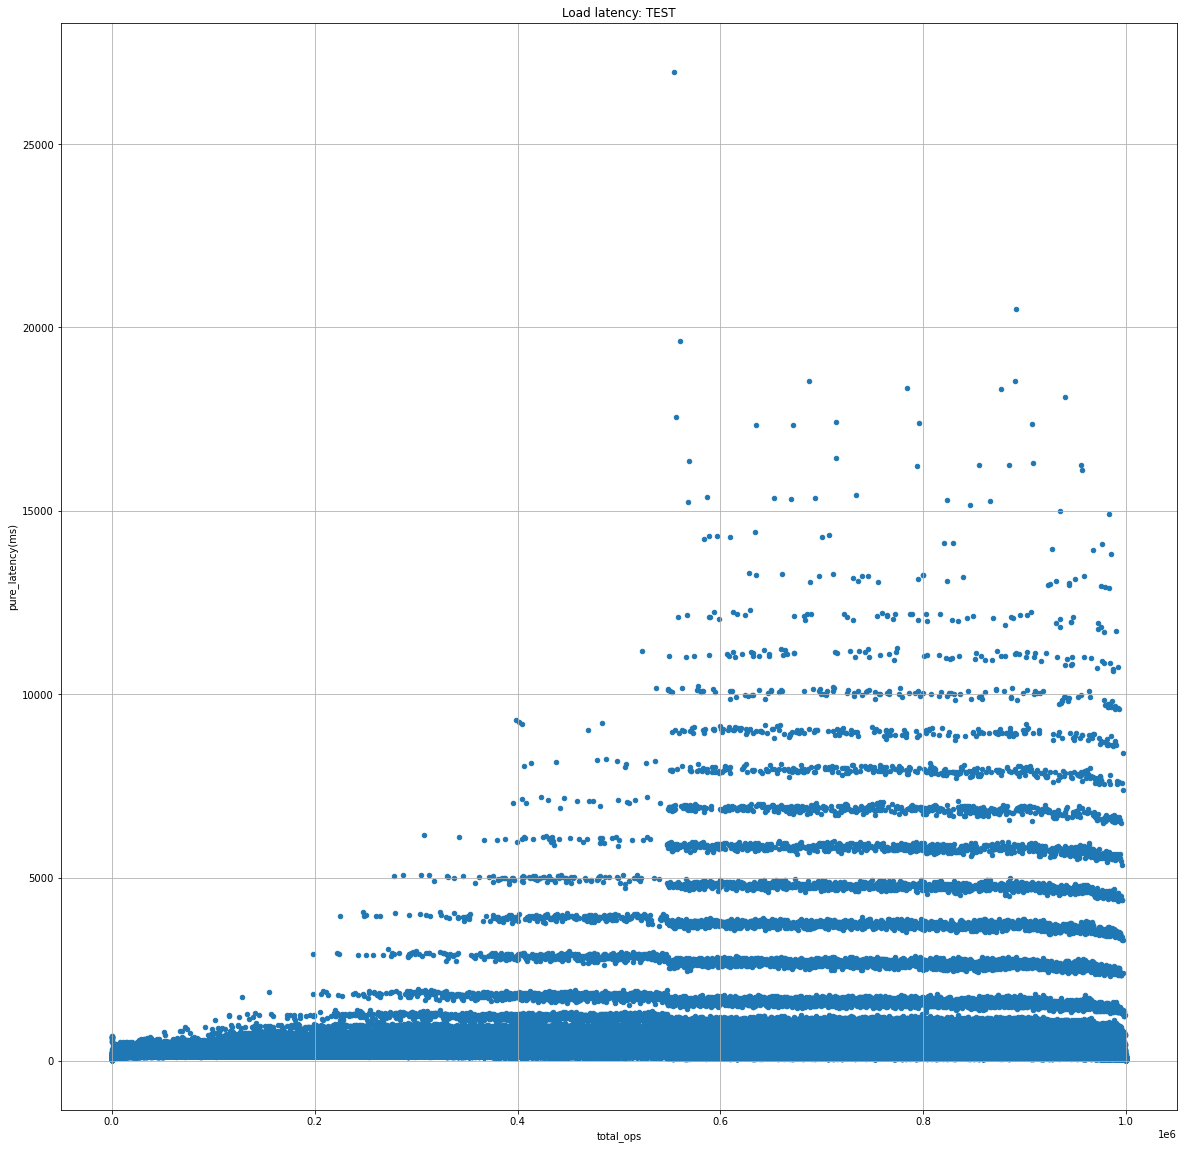

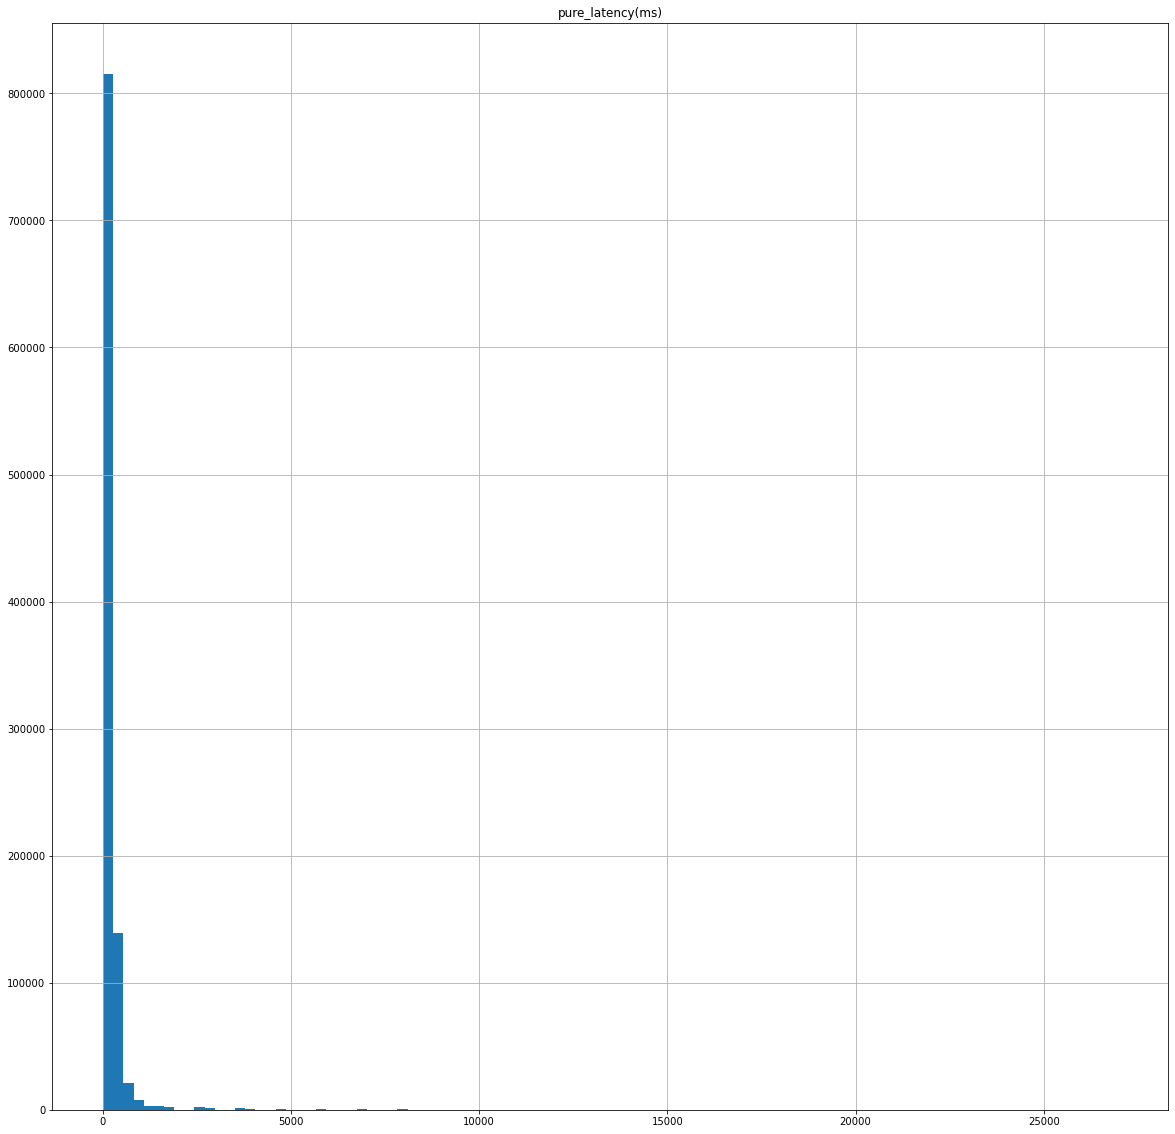

In [9]:
# df = get_summary_statistics_df(pc_e)


# df.to_csv("/tmp/summary.csv")
# df

df_w = pc_e.get_data().diff_data

# Graph scatter plot of latency
df_w.plot(figsize=(20,20), x="total_ops", y= "pure_latency(ms)", kind="scatter", title=f"Load latency: TEST", ylabel="pure_latency(ms)", grid=0.4)

# Graph latency with trend lines
# plot_latency_stats(df_w, "total_ops", title=f"{experiment} cf_{cf} thread_{tc} insert stats", regr="log", start=start, end=end)
# df_h = df_w.query("`pure_latency(ms)` < 10")

df_w.hist(figsize=(20,20), column= "pure_latency(ms)", bins=100, grid=0.4)

<AxesSubplot: title={'center': 'NEW ES2 Load: Average Latency'}, xlabel='ContentionFactor', ylabel='Average Latency'>

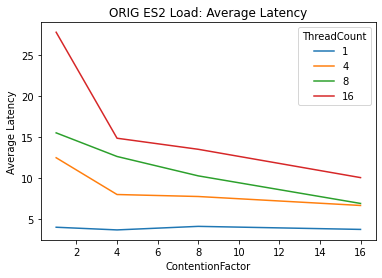

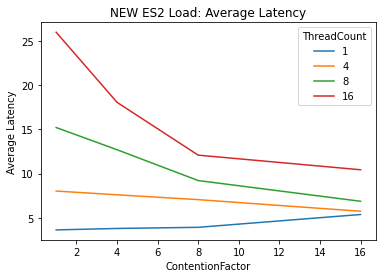

In [56]:
# Make a pivot table for average latency for load and graph it
query = "QueryNumber == 'load' & Experiment == 'es2'"

pd_orig = pandas.read_csv(csv_orig_file)

# un_pd1_orig = pd_orig.query("QueryNumber == 'load' & Experiment == 'es1'")
#un_piv_orig = un_pd1_orig.pivot(index='ContentionFactor', columns="ThreadCount", values="AverageLatencyMillis")

pd1_orig = pd_orig.query(query)
piv_orig = pd1_orig.pivot(index='ContentionFactor', columns="ThreadCount", values="AverageLatencyMillis")

pd_new = pandas.read_csv(csv_new_file)
pd1_new = pd_new.query(query)
piv_new = pd1_new.pivot(index='ContentionFactor', columns="ThreadCount", values="AverageLatencyMillis")


# un_pd1_orig.plot(title="ORIG ES1 Load: Average Latency", ylabel="Average Latency")

piv_orig.plot(title="ORIG ES2 Load: Average Latency", ylabel="Average Latency")
piv_new.plot(title="NEW ES2 Load: Average Latency", ylabel="Average Latency")
